# Análisis de Participación Electoral - Barómetros CIS (2016-2025)

Este notebook construye tres series temporales de propensión a la participación/abstención electoral:

1. **Serie 1 (Escala 0-10)**: Probabilidad declarada de ir a votar (serie rica, con hueco 2020-2022)
2. **Serie 2 (Homogeneizada)**: % abstención probable (combina fuentes, serie continua)
3. **Serie 3 ("No votaría")**: % que responde "No votaría" en intención de voto

Indicadores calculados para **España** y las **17 CCAA**.

In [1]:
# =============================================================================
# CELDA 1: CONFIGURACIÓN
# =============================================================================

import pandas as pd
import numpy as np
import pyreadstat
import os
import glob
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# --- RUTAS ---
CARPETA_RAIZ = ".."
CARPETA_RAW = os.path.join(CARPETA_RAIZ, "data", "raw", "cis", "barómetro")
CARPETA_OUTPUT = os.path.join(CARPETA_RAIZ, "data", "processed", "cis", "participacion")
CARPETA_CACHE = os.path.join(CARPETA_RAW, 'microdatoscompleto')
ARCHIVO_PARQUET = os.path.join(CARPETA_CACHE, 'microdatos_participacion.parquet')

# Crear carpetas si no existen
os.makedirs(CARPETA_OUTPUT, exist_ok=True)
os.makedirs(CARPETA_CACHE, exist_ok=True)

# --- ESTUDIOS A EXCLUIR ---
ESTUDIOS_EXCLUIR = [3468]

# --- CÓDIGOS DE CCAA ---
CCAA_NOMBRES = {
    1: 'Andalucía', 2: 'Aragón', 3: 'Asturias', 4: 'Baleares',
    5: 'Canarias', 6: 'Cantabria', 7: 'Castilla-La Mancha', 8: 'Castilla y León',
    9: 'Cataluña', 10: 'C. Valenciana', 11: 'Extremadura', 12: 'Galicia',
    13: 'Madrid', 14: 'Murcia', 15: 'Navarra', 16: 'País Vasco', 17: 'La Rioja'
}

print("✅ Configuración cargada")
print(f"   📁 Carpeta raw: {CARPETA_RAW}")
print(f"   📁 Carpeta output: {CARPETA_OUTPUT}")

c:\Users\Usuario\anaconda3\envs\tftimeseriesII\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Usuario\anaconda3\envs\tftimeseriesII\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\Usuario\anaconda3\envs\tftimeseriesII\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


✅ Configuración cargada
   📁 Carpeta raw: ..\data\raw\cis\barómetro
   📁 Carpeta output: ..\data\processed\cis\participacion


In [2]:
# =============================================================================
# CELDA 2: MAPEO DE VARIABLES DE PARTICIPACIÓN ELECTORAL
# =============================================================================

# Diccionario de fechas por estudio (para ordenar series)
FECHAS_ESTUDIO = {
    3124: '2016-01', 3128: '2016-02', 3131: '2016-03', 3134: '2016-04',
    3138: '2016-05', 3142: '2016-06', 3149: '2016-09', 3156: '2016-10',
    3159: '2016-11', 3162: '2016-12', 3164: '2017-01', 3168: '2017-02',
    3170: '2017-03', 3173: '2017-04', 3175: '2017-05', 3179: '2017-06',
    3183: '2017-07', 3187: '2017-09', 3191: '2017-10', 3195: '2017-11',
    3199: '2017-12', 3203: '2018-01', 3205: '2018-02', 3207: '2018-03',
    3210: '2018-04', 3213: '2018-05', 3217: '2018-06', 3219: '2018-07',
    3223: '2018-09', 3226: '2018-10', 3231: '2018-11', 3234: '2018-12',
    3238: '2019-01', 3240: '2019-02', 3247: '2019-05', 3252: '2019-06',
    3261: '2019-09', 3267: '2019-11', 3271: '2020-01', 3273: '2020-02',
    3277: '2020-03', 3279: '2020-04', 3281: '2020-05', 3283: '2020-06',
    3288: '2020-07', 3292: '2020-09', 3296: '2020-10', 3300: '2020-11',
    3303: '2020-12', 3307: '2021-02', 3309: '2021-03', 3313: '2021-04',
    3318: '2021-04', 3322: '2021-05', 3326: '2021-06', 3330: '2021-07',
    3334: '2021-09', 3337: '2021-10', 3340: '2021-10', 3344: '2021-12',
    3347: '2022-01', 3351: '2022-02', 3355: '2022-03', 3359: '2022-04',
    3363: '2022-05', 3366: '2022-06', 3371: '2022-07', 3375: '2022-10',
    3380: '2022-11', 3384: '2022-12', 3388: '2022-12', 3390: '2023-01',
    3395: '2023-02', 3398: '2023-03', 3403: '2023-04', 3405: '2023-05',
    3413: '2023-07', 3423: '2023-10', 3427: '2023-11', 3431: '2023-12',
    3435: '2024-01', 3441: '2024-02', 3445: '2024-03', 3450: '2024-04',
    3457: '2024-05', 3463: '2024-06', 3474: '2024-09', 3478: '2024-10',
    3485: '2024-11', 3489: '2024-12', 3492: '2025-01', 3510: '2025-05',
    3524: '2025-09', 3536: '2025-12'
}

# --- ESCALA 0-10: Probabilidad de ir a votar ---
# Variable estandarizada: PROBVOTO
MAPEO_PROBVOTO = {
    # 2016
    3142: 'P22',
    # 2017
    3168: 'P23',
    3175: 'P25',
    # 2018
    3213: 'P18',
    # 2019
    3247: 'P16',
    3261: 'P15',
    3267: 'A15',
    # 2020
    3271: 'A15',
    3273: 'A14',
    3277: 'A16',
    3283: 'P29',
    # 2022 (reaparece)
    3363: 'P23',
    3375: 'PROBVOTO',
    3380: 'PROBVOTO',
    3384: 'PROBVOTO',
    3388: 'PROBVOTO',
    # 2023+
    3390: 'PROBVOTO', 3395: 'PROBVOTO', 3398: 'PROBVOTO', 3403: 'PROBVOTO',
    3405: 'PROBVOTO', 3413: 'PROBVOTO', 3423: 'PROBVOTO', 3427: 'PROBVOTO',
    3431: 'PROBVOTO', 3435: 'PROBVOTO', 3441: 'PROBVOTO', 3445: 'PROBVOTO',
    3450: 'PROBVOTPE', 3457: 'PROBVOTO', 3463: 'PROBVOTO', 3474: 'PROBVOTO',
    3478: 'PROBVOTO', 3485: 'PROBVOTO', 3489: 'PROBVOTO', 3492: 'PROBVOTO',
    3510: 'PROBVOTO', 3524: 'PROBVOTO', 3536: 'PROBVOTO'
}

# --- 4 CATEGORÍAS: Iría a votar con seguridad / Probablemente sí / etc. ---
# Variable estandarizada: PARTICIP_4CAT
MAPEO_PARTICIP_4CAT = {
    3175: 'P24',  # May 2017
    3187: 'P19',  # Sep 2017
    3199: 'P25',  # Dic 2017
    3213: 'P19',  # May 2018
    3238: 'P24',  # Ene 2019
}

# --- INTENCIÓN DE VOTO (contiene "No votaría") ---
# Variable estandarizada: INTENCION_VOTO
# Código "No votaría" generalmente = 97
MAPEO_INTENCION_VOTO = {
    # 2016
    3124: 'P16R', 3128: 'P16R', 3131: 'P16R', 3134: 'P15',
    3138: 'P16R', 3142: 'P16R', 3149: 'P16R', 3156: 'P16R',
    3159: 'P16R', 3162: 'P16R',
    # 2017
    3164: 'P16R', 3168: 'P16R', 3170: 'P16R', 3173: 'P16R',
    3175: 'P16R', 3179: 'P16R', 3183: 'P16R', 3187: 'P16R',
    3191: 'P16R', 3195: 'P16R', 3199: 'P16R',
    # 2018
    3203: 'P16R', 3205: 'P16R', 3207: 'P16R', 3210: 'P16R',
    3213: 'P16R', 3217: 'P16R', 3219: 'P16R', 3223: 'P16R',
    3226: 'P16R', 3231: 'P24', 3234: 'P16R',
    # 2019
    3238: 'P16R', 3240: 'P16R', 3247: 'P20', 3252: 'P16R',
    3261: 'P16R', 3267: 'C1R',
    # 2020
    3271: 'C1R', 3273: 'C1R', 3277: 'C1R', 3279: 'P27',
    3281: 'P29', 3283: 'P16R', 3288: 'P16R', 3292: 'P21',
    3296: 'P21', 3300: 'P21', 3303: 'P21',
    # 2021
    3307: 'P21', 3309: 'P21', 3313: 'P21', 3318: 'P29',
    3322: 'P21', 3326: 'P21', 3330: 'P24', 3334: 'P21',
    3337: 'P21', 3340: 'P21', 3344: 'P22',
    # 2022
    3347: 'P21', 3351: 'P24', 3355: 'P21', 3359: 'P21',
    3363: 'P21', 3366: 'P12', 3371: 'P16', 3375: 'P16R',
    3380: 'P16R', 3384: 'P16R', 3388: 'P16R',
    # 2023+
    3390: 'P16R', 3395: 'P16R', 3398: 'P16R', 3403: 'P16R',
    3405: 'P16R', 3413: 'P16R', 3423: 'P16R', 3427: 'P16R',
    3431: 'P16R', 3435: 'P16R', 3441: 'P16R', 3445: 'P16R',
    3450: 'P16R', 3457: 'P16R', 3463: 'P16R', 3474: 'P16R',
    3478: 'P16R', 3485: 'P16R', 3489: 'P16R', 3492: 'P16R',
    3510: 'P16R', 3524: 'P16R', 3536: 'P16R'
}

# Códigos para "No votaría" según tipo de variable
CODIGO_NO_VOTARIA = 97  # Código más común

print(f"✅ Mapeos definidos:")
print(f"   - Escala 0-10: {len(MAPEO_PROBVOTO)} estudios")
print(f"   - 4 categorías: {len(MAPEO_PARTICIP_4CAT)} estudios")
print(f"   - Intención voto: {len(MAPEO_INTENCION_VOTO)} estudios")

✅ Mapeos definidos:
   - Escala 0-10: 39 estudios
   - 4 categorías: 5 estudios
   - Intención voto: 94 estudios


In [3]:
# =============================================================================
# CELDA 3: FUNCIÓN DE CARGA DE MICRODATOS
# =============================================================================

def cargar_microdatos_participacion(carpeta, estudios_excluir=None, estudios_a_cargar=None):
    """
    Carga archivos .sav del CIS y estandariza las variables de participación.
    """
    estudios_excluir = estudios_excluir or []
    
    # Identificar archivos
    archivos_sav = sorted(set(
        glob.glob(os.path.join(carpeta, '**/*.sav'), recursive=True) +
        glob.glob(os.path.join(carpeta, '**/*.SAV'), recursive=True)
    ))
    
    # Filtrar por estudios específicos si se solicita
    if estudios_a_cargar is not None:
        archivos_sav = [
            f for f in archivos_sav 
            if int(re.sub(r'[^0-9]', '', os.path.basename(f).replace('.sav', '').replace('.SAV', ''))) in estudios_a_cargar
        ]
        
    print(f"📂 Procesando {len(archivos_sav)} archivos .sav")
    
    dfs = []
    for archivo in tqdm(archivos_sav, desc="📊 Cargando"):
        nombre = os.path.basename(archivo)
        num_estudio = int(re.sub(r'[^0-9]', '', nombre.replace('.sav', '').replace('.SAV', '')))
        
        if num_estudio in estudios_excluir:
            continue
            
        try:
            # Leer solo metadatos primero para ver columnas (opcional, pero pyreadstat es rápido)
            df, meta = pyreadstat.read_sav(archivo)
            
            # --- RENOMBRADO DINÁMICO ---
            renombrar = {}
            
            # 1. PROBVOTO
            if num_estudio in MAPEO_PROBVOTO:
                renombrar[MAPEO_PROBVOTO[num_estudio]] = 'PROBVOTO'
            
            # 2. PARTICIP_4CAT
            if num_estudio in MAPEO_PARTICIP_4CAT:
                renombrar[MAPEO_PARTICIP_4CAT[num_estudio]] = 'PARTICIP_4CAT'
                
            # 3. INTENCION_VOTO
            if num_estudio in MAPEO_INTENCION_VOTO:
                renombrar[MAPEO_INTENCION_VOTO[num_estudio]] = 'INTENCION_VOTO'
            
            df = df.rename(columns=renombrar)
            
            # --- DEDUPLICACIÓN DE COLUMNAS ---
            # Si el archivo ya traía la columna destino, rename crea duplicados.
            # Nos quedamos con la primera ocurrencia (normalmente la renombrada).
            if not df.columns.is_unique:
                df = df.loc[:, ~df.columns.duplicated()]
            
            # --- ESTANDARIZACIÓN ---
            if 'ESTU' not in df.columns: df['ESTU'] = num_estudio
            
            # Columnas mínimas requeridas
            cols_deseadas = ['ESTU', 'CUES', 'CCAA', 'INTENCION_VOTO', 'PROBVOTO', 'PARTICIP_4CAT', 'PESO']
            cols_finales = [c for c in cols_deseadas if c in df.columns]
            
            dfs.append(df[cols_finales].copy())
            
        except Exception as e:
            print(f"   ⚠️ Error en estudio {num_estudio}: {e}")
            
    if not dfs:
        return pd.DataFrame()
        
    return pd.concat(dfs, ignore_index=True, sort=False)

print("✅ Función cargar_microdatos_participacion definida")


✅ Función cargar_microdatos_participacion definida


In [6]:
# =============================================================================
# CELDA 4: CARGA DE DATOS CON CACHÉ E INTEGRACIÓN DE FECHAS
# =============================================================================

print("🔍 Cargando diccionario de fechas y verificando microdatos...")

# 1. Cargar Diccionario de Fechas Automático
df_fechas = pd.read_csv(os.path.join(CARPETA_RAW, '_diccionario_fechas.csv'))
df_fechas['FECHA'] = pd.to_datetime(df_fechas['FECHA'])
DICT_FECHAS = dict(zip(df_fechas['ESTU'], df_fechas['FECHA']))
print(f"   📅 Fechas cargadas: {len(DICT_FECHAS)} estudios")

# 2. Identificar todos los estudios disponibles en carpeta
archivos_sav = sorted(set(
    glob.glob(os.path.join(CARPETA_RAW, '**/*.sav'), recursive=True) +
    glob.glob(os.path.join(CARPETA_RAW, '**/*.SAV'), recursive=True)
))

estudios_disponibles = set()
for archivo in archivos_sav:
    nombre = os.path.basename(archivo)
    num_estudio = int(re.sub(r'[^0-9]', '', nombre.replace('.sav', '').replace('.SAV', '')))
    if num_estudio not in ESTUDIOS_EXCLUIR:
        estudios_disponibles.add(num_estudio)

print(f"   Estudios disponibles en carpeta: {len(estudios_disponibles)}")

# 3. Verificar caché
if os.path.exists(ARCHIVO_PARQUET):
    df_micro = pd.read_parquet(ARCHIVO_PARQUET)
    estudios_en_cache = set(df_micro['ESTU'].unique())
    print(f"   Estudios ya en caché: {len(estudios_en_cache)}")
    
    estudios_nuevos = estudios_disponibles - estudios_en_cache
    
    if estudios_nuevos:
        print(f"   🆕 Estudios nuevos detectados: {len(estudios_nuevos)}")
        df_nuevos = cargar_microdatos_participacion(CARPETA_RAW, ESTUDIOS_EXCLUIR, estudios_nuevos)
        df_micro = pd.concat([df_micro, df_nuevos], ignore_index=True, sort=False)
    else:
        print(f"   ✅ Caché actualizado")
else:
    print(f"   📦 Cargando todos los estudios por primera vez...")
    # Cargamos SOLO el 3124 para estar 100% seguros
    # Cargamos 3124 y 3134
    df_micro = cargar_microdatos_participacion(CARPETA_RAW, ESTUDIOS_EXCLUIR, estudios_a_cargar=[3124, 3134])

# 4. Rellenar PESO faltante con 1
if 'PESO' in df_micro.columns:
    df_micro['PESO'] = df_micro['PESO'].fillna(1)
else:
    df_micro['PESO'] = 1

# 5. Asignar Fechas Automáticamente
df_micro['FECHA_DT'] = df_micro['ESTU'].map(DICT_FECHAS)
df_micro['FECHA'] = df_micro['FECHA_DT'].dt.strftime('%Y-%m')

# Verificar estudios sin fecha
sin_fecha = df_micro[df_micro['FECHA_DT'].isna()]['ESTU'].unique()
if len(sin_fecha) > 0:
    print(f"   ⚠️ Estudios sin fecha asignada: {sorted(sin_fecha)}")

# 6. Guardar caché
print(f"\n💾 Guardando caché actualizado en {ARCHIVO_PARQUET}...")
df_micro.to_parquet(ARCHIVO_PARQUET, index=False, compression='snappy')

# Reporte Final
print(f"\n📊 Dataset consolidado:")
print(f"   Filas: {len(df_micro):,}")
print(f"   Estudios únicos: {df_micro['ESTU'].nunique()}")
print(f"   Rango temporal: {df_micro['FECHA'].min()} a {df_micro['FECHA'].max()}")


🔍 Cargando diccionario de fechas y verificando microdatos...
   📅 Fechas cargadas: 102 estudios
   Estudios disponibles en carpeta: 101
   Estudios ya en caché: 1
   🆕 Estudios nuevos detectados: 100
📂 Procesando 100 archivos .sav


📊 Cargando:   1%|          | 1/100 [00:08<13:54,  8.43s/it]


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\Usuario\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Usuario\AppData\Local\Temp\ipykernel_30412\450049346.py", line 38, in <module>
    df_nuevos = cargar_microdatos_participacion(CARPETA_RAW, ESTUDIOS_EXCLUIR, estudios_nuevos)
  File "C:\Users\Usuario\AppData\Local\Temp\ipykernel_30412\3824297371.py", line 36, in cargar_microdatos_participacion
    df, meta = pyreadstat.read_sav(archivo)
  File "pyreadstat\\pyreadstat.pyx", line 389, in pyreadstat.pyreadstat.read_sav
  File "pyreadstat\\_readstat_parser.pyx", line 1142, in pyreadstat._readstat_parser.run_conversion
  File "pyreadstat\\_readstat_parser.pyx", line 933, in pyreadstat._readstat_parser.dict_to_pandas_dataframe
  File "c:\Users\Usuario\anaconda3\envs\tftimeseriesII\lib\site-packages\pandas\core\frame.py", line 1510, in from_dict
    @classmethod

In [12]:
import pyreadstat
import os

estudios_a_ver = ["3159", "3162", "3164"]

for estu in estudios_a_ver:
    ruta = os.path.join(CARPETA_RAW, f"{estu}.sav")
    if os.path.exists(ruta):
        _, meta = pyreadstat.read_sav(ruta, metadataonly=True)
        print(f"\n--- Estructura del Estudio {estu} ---")
        for i, col in enumerate(meta.column_names):
            # Miramos el bloque central donde suele estar la política
            if i >= 10 and i <= 60: 
                label = meta.column_labels[i] or "SIN ETIQUETA"
                print(f"  {col}: {label}")
    else:
        print(f"Archivo {estu}.sav no encontrado")


--- Estructura del Estudio 3159 ---
  P0: Nacionalidad de la persona entrevistada
  P0A: Nacionalidad de la persona entrevistada (extranjeros)
  P1: Valoración de la situación económica general de España
  P2: Valoración retrospectiva de la situación económica de España (1 año)
  P3: Valoración prospectiva de la situación económica de España (1 año)
  P4: Valoración de la situación política general de España
  P5: Valoración retrospectiva de la situación política de España (1 año)
  P6: Valoración prospectiva de la situación política de España (1 año)
  P701: Primer problema
  P702: Segundo problema
  P703: Tercer problema
  P801: Primer problema
  P802: Segundo problema
  P803: Tercer problema
  P901: Cultura
  P902: Temas económicos y laborales
  P903: Temas políticos
  P904: Avances científicos y tecnológicos
  P905: Temas internacionales
  P906: Ecología y medio ambiente
  P907: Avances médicos
  P10: Grado de información sobre el medio ambiente
  P10A01: 1ª fuente de información


In [5]:
# =============================================================================
# CELDA 5: CREACIÓN DE INDICADORES DERIVADOS
# =============================================================================

print("🔧 Creando indicadores derivados...")

# --- Indicador 1: Abstención probable (escala 0-10) ---
# % con probabilidad <= 4 (Umbral conservador de abstención)
if 'PROBVOTO' in df_micro.columns:
    df_micro['ABSTENCION_ESCALA'] = (df_micro['PROBVOTO'] <= 4).astype(float)
    df_micro.loc[df_micro['PROBVOTO'].isna(), 'ABSTENCION_ESCALA'] = np.nan
    # Códigos especiales del CIS para NS/NC suelen ser 98, 99
    df_micro.loc[df_micro['PROBVOTO'] > 10, 'ABSTENCION_ESCALA'] = np.nan
    print(f"   ✅ ABSTENCION_ESCALA creada")

# --- Indicador 2: Abstención (4 categorías) ---
# "Probablemente no" (3) + "No iría con seguridad" (4)
if 'PARTICIP_4CAT' in df_micro.columns:
    df_micro['ABSTENCION_4CAT'] = (df_micro['PARTICIP_4CAT'] >= 3).astype(float)
    df_micro.loc[df_micro['PARTICIP_4CAT'].isna(), 'ABSTENCION_4CAT'] = np.nan
    # Excluir NS/NC (códigos >= 8)
    df_micro.loc[df_micro['PARTICIP_4CAT'] >= 8, 'ABSTENCION_4CAT'] = np.nan
    print(f"   ✅ ABSTENCION_4CAT creada")

# --- Indicador 3: "No votaría" en intención de voto ---
# Se busca el código correspondiente a "No votaría" / "Abstención"
if 'INTENCION_VOTO' in df_micro.columns:
    # Por defecto usamos 97, pero el script de carga podría haber detectado otros
    df_micro['NO_VOTARIA'] = (df_micro['INTENCION_VOTO'] == 97).astype(float)
    df_micro.loc[df_micro['INTENCION_VOTO'].isna(), 'NO_VOTARIA'] = np.nan
    print(f"   ✅ NO_VOTARIA creada")

# --- Filtrar CCAA válidas (1-17) ---
if 'CCAA' in df_micro.columns:
    df_micro['CCAA'] = pd.to_numeric(df_micro['CCAA'], errors='coerce')
    # Eliminar Ceuta y Melilla si existen (18, 19) para homogeneidad regional
    df_micro.loc[df_micro['CCAA'] > 17, 'CCAA'] = np.nan
    print(f"   ✅ CCAA normalizada")

print(f"\n📊 Resumen de indicadores (medias sin ponderar):")
for col in ['ABSTENCION_ESCALA', 'ABSTENCION_4CAT', 'NO_VOTARIA']:
    if col in df_micro.columns:
        media = df_micro[col].mean() * 100
        print(f"   {col}: {media:.2f}%")

🔧 Creando indicadores derivados...
   ✅ ABSTENCION_ESCALA creada
   ✅ ABSTENCION_4CAT creada
   ✅ NO_VOTARIA creada
   ✅ CCAA normalizada

📊 Resumen de indicadores (medias sin ponderar):
   ABSTENCION_ESCALA: 15.53%
   ABSTENCION_4CAT: 34.28%
   NO_VOTARIA: 11.14%


In [6]:
# =============================================================================
# CELDA 6: CÁLCULO DE SERIES NACIONALES (ESPAÑA)
# =============================================================================

print("📈 Calculando series para ESPAÑA con pesos ponderados...")

resultados_espana = []

for estu in tqdm(df_micro['ESTU'].unique(), desc="Procesando estudios"):
    grupo = df_micro[df_micro['ESTU'] == estu].copy()
    
    # Identificar columna de peso dinámicamente (priorizar PESO)
    col_peso = 'PESO' if 'PESO' in grupo.columns else None
    peso = grupo[col_peso].fillna(1) if col_peso else np.ones(len(grupo))
    
    resultado = {'ESTU': estu}
    
    # 1. ABSTENCION_ESCALA (% ponderado)
    if 'ABSTENCION_ESCALA' in grupo.columns:
        mask = grupo['ABSTENCION_ESCALA'].notna()
        if mask.any():
            resultado['ABSTENCION_ESCALA'] = np.average(grupo.loc[mask, 'ABSTENCION_ESCALA'], weights=peso[mask]) * 100
            resultado['N_ESCALA'] = mask.sum()
            
    # 2. ABSTENCION_4CAT (% ponderado)
    if 'ABSTENCION_4CAT' in grupo.columns:
        mask = grupo['ABSTENCION_4CAT'].notna()
        if mask.any():
            resultado['ABSTENCION_4CAT'] = np.average(grupo.loc[mask, 'ABSTENCION_4CAT'], weights=peso[mask]) * 100
            resultado['N_4CAT'] = mask.sum()
            
    # 3. NO_VOTARIA (% ponderado)
    if 'NO_VOTARIA' in grupo.columns:
        mask = grupo['NO_VOTARIA'].notna()
        if mask.any():
            resultado['NO_VOTARIA'] = np.average(grupo.loc[mask, 'NO_VOTARIA'], weights=peso[mask]) * 100
            resultado['N_NO_VOTARIA'] = mask.sum()

    resultados_espana.append(resultado)

df_espana = pd.DataFrame(resultados_espana)

# Unir con fechas del diccionario
df_espana['FECHA_DT'] = df_espana['ESTU'].map(DICT_FECHAS)
df_espana = df_espana.sort_values('FECHA_DT')
df_espana['FECHA'] = df_espana['FECHA_DT'].dt.strftime('%Y-%m')
df_espana['TERRITORIO'] = 'España'

print(f"\n✅ Serie España generada: {len(df_espana)} estudios")
df_espana.head(5)


📈 Calculando series para ESPAÑA con pesos ponderados...


Procesando estudios: 100%|██████████| 101/101 [00:00<00:00, 614.55it/s]


✅ Serie España generada: 101 estudios


,ESTU,NO_VOTARIA,N_NO_VOTARIA,ABSTENCION_ESCALA,N_ESCALA,ABSTENCION_4CAT,N_4CAT,FECHA_DT,FECHA,TERRITORIO
0,3124.0,10.096154,2496.0,NaN,NaN,NaN,NaN,2016-01-01,2016-01,España
1,3128.0,NaN,NaN,NaN,NaN,NaN,NaN,2016-02-01,2016-02,España
2,3131.0,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-01,2016-03,España
3,3134.0,27.791165,2490.0,NaN,NaN,NaN,NaN,2016-04-01,2016-04,España
4,3138.0,NaN,NaN,NaN,NaN,NaN,NaN,2016-05-01,2016-05,España


In [7]:
# =============================================================================
# CELDA 7: CÁLCULO DE SERIES REGIONALES (CCAA) CON SUAVIZADO
# =============================================================================

print("📈 Calculando series para las 17 CCAA...")

resultados_ccaa = []
ccaa_validas = df_micro[df_micro['CCAA'].between(1, 17)]

for (estu, ccaa), grupo in tqdm(ccaa_validas.groupby(['ESTU', 'CCAA']), desc="Procesando CCAA"):
    # Lógica de pesos por CCAA
    # Si existe PESOPROV o similar, podría usarse, pero por ahora PESO es más seguro
    col_peso = 'PESO' if 'PESO' in grupo.columns else None
    peso = grupo[col_peso].fillna(1) if col_peso else np.ones(len(grupo))
    
    resultado = {'ESTU': estu, 'CCAA': ccaa}
    
    for col in ['ABSTENCION_ESCALA', 'ABSTENCION_4CAT', 'NO_VOTARIA']:
        if col in grupo.columns:
            mask = grupo[col].notna()
            if mask.any():
                resultado[col] = np.average(grupo.loc[mask, col], weights=peso[mask]) * 100
                resultado[f'N_{col.split("_")[-1]}'] = mask.sum()
                
    resultados_ccaa.append(resultado)

df_ccaa = pd.DataFrame(resultados_ccaa)

# 1. Mapeo de nombres y fechas
df_ccaa['TERRITORIO'] = df_ccaa['CCAA'].map(CCAA_NOMBRES)
df_ccaa['FECHA_DT'] = df_ccaa['ESTU'].map(DICT_FECHAS)
df_ccaa = df_ccaa.sort_values(['CCAA', 'FECHA_DT'])

# 2. APLICAR SUAVIZADO (Media móvil 3 meses) por cada CCAA
print("🌊 Aplicando suavizado (media móvil 3 meses) a las series regionales...")
cols_to_smooth = ['ABSTENCION_ESCALA', 'ABSTENCION_4CAT', 'NO_VOTARIA']
for col in cols_to_smooth:
    if col in df_ccaa.columns:
        df_ccaa[f'{col}_SUAVE'] = df_ccaa.groupby('CCAA')[col].transform(lambda x: x.rolling(window=3, min_periods=1, center=False).mean())

df_ccaa['FECHA'] = df_ccaa['FECHA_DT'].dt.strftime('%Y-%m')

print(f"\n✅ Series CCAA generadas con suavizado")
df_ccaa[['FECHA', 'TERRITORIO', 'ABSTENCION_ESCALA', 'ABSTENCION_ESCALA_SUAVE']].tail(10)


📈 Calculando series para las 17 CCAA...


Procesando CCAA: 100%|██████████| 1717/1717 [00:01<00:00, 1515.24it/s]

🌊 Aplicando suavizado (media móvil 3 meses) a las series regionales...

✅ Series CCAA generadas con suavizado


,FECHA,TERRITORIO,ABSTENCION_ESCALA,ABSTENCION_ESCALA_SUAVE
1563,2025-02,La Rioja,17.333054,19.545125
1580,2025-03,La Rioja,17.957364,17.527659
1597,2025-04,La Rioja,11.847484,15.712634
1614,2025-05,La Rioja,21.014651,16.939833
1631,2025-06,La Rioja,8.360971,13.741035
1648,2025-07,La Rioja,12.758998,14.044873
1665,2025-09,La Rioja,8.184755,9.768241
1682,2025-10,La Rioja,9.375000,10.106251
1699,2025-11,La Rioja,20.079899,12.546551
1716,2025-12,La Rioja,16.613740,15.356213


In [8]:
# =============================================================================
# CELDA 8: CREAR SERIE HOMOGENEIZADA CON AJUSTE DE FUENTE
# =============================================================================

print("🔧 Creando serie homogeneizada de abstención probable...")

def crear_serie_homogeneizada(df, territorial='España'):
    """
    Crea un indicador único de abstención combinando fuentes por prioridad:
    1. Escala 0-10 (ABSTENCION_ESCALA) -> Fuente Base
    2. 4 categorías (ABSTENCION_4CAT) -> Ajustada (si hay solape)
    3. No votaría (NO_VOTARIA) -> Ajustada como fallback
    """
    df = df.copy()
    
    # Identificar columnas a usar (preferir las suavizadas para CCAA)
    col_escala = 'ABSTENCION_ESCALA_SUAVE' if 'ABSTENCION_ESCALA_SUAVE' in df.columns else 'ABSTENCION_ESCALA'
    col_4cat = 'ABSTENCION_4CAT_SUAVE' if 'ABSTENCION_4CAT_SUAVE' in df.columns else 'ABSTENCION_4CAT'
    col_no_vota = 'NO_VOTARIA_SUAVE' if 'NO_VOTARIA_SUAVE' in df.columns else 'NO_VOTARIA'

    df['ABSTENCION_HOMOG'] = np.nan
    df['FUENTE_HOMOG'] = ''
    
    # --- PASO 1: Prioridad Escala 0-10 ---
    if col_escala in df.columns:
        mask = df[col_escala].notna()
        df.loc[mask, 'ABSTENCION_HOMOG'] = df.loc[mask, col_escala]
        df.loc[mask, 'FUENTE_HOMOG'] = 'Escala 0-10'
    
    # --- PASO 2: Integrar 4 Categorías con Factor de Corrección ---
    # Se calcula la diferencia media en periodos de solape si existen
    if col_4cat in df.columns:
        solape = df[df[col_escala].notna() & df[col_4cat].notna()]
        factor = 1.0
        if len(solape) > 0:
            factor = solape[col_escala].mean() / solape[col_4cat].mean()
            # print(f"   ℹ️ Factor de corrección 4CAT ({territorial}): {factor:.2f}")
        
        mask = df['ABSTENCION_HOMOG'].isna() & df[col_4cat].notna()
        df.loc[mask, 'ABSTENCION_HOMOG'] = df.loc[mask, col_4cat] * factor
        df.loc[mask, 'FUENTE_HOMOG'] = '4 categorías'

    # --- PASO 3: Integrar No Votaría (Intención) con Factor de Corrección ---
    if col_no_vota in df.columns:
        solape = df[df[col_escala].notna() & df[col_no_vota].notna()]
        factor = 1.5 # Factor por defecto si no hay solape (históricamente la abstención real es mayor)
        if len(solape) > 0:
            factor = solape[col_escala].mean() / solape[col_no_vota].mean()
        
        mask = df['ABSTENCION_HOMOG'].isna() & df[col_no_vota].notna()
        df.loc[mask, 'ABSTENCION_HOMOG'] = df.loc[mask, col_no_vota] * factor
        df.loc[mask, 'FUENTE_HOMOG'] = 'No votaría (ajustado)'
    
    return df

# Aplicar a España
df_espana = crear_serie_homogeneizada(df_espana, 'España')

# Aplicar a CCAA (vía groupby para calcular factores locales si es posible)
df_ccaa_list = []
for terr, grupo in df_ccaa.groupby('TERRITORIO'):
    df_ccaa_list.append(crear_serie_homogeneizada(grupo, terr))
df_ccaa = pd.concat(df_ccaa_list).sort_values(['CCAA', 'FECHA_DT'])

print(f"\n✅ Serie homogeneizada creada con corrección de sesgo")
print(f"\n📊 Cobertura temporal (España): {df_espana['FECHA'].min()} a {df_espana['FECHA'].max()}")


🔧 Creando serie homogeneizada de abstención probable...

✅ Serie homogeneizada creada con corrección de sesgo

📊 Cobertura temporal (España): 2016-01 a 2025-12


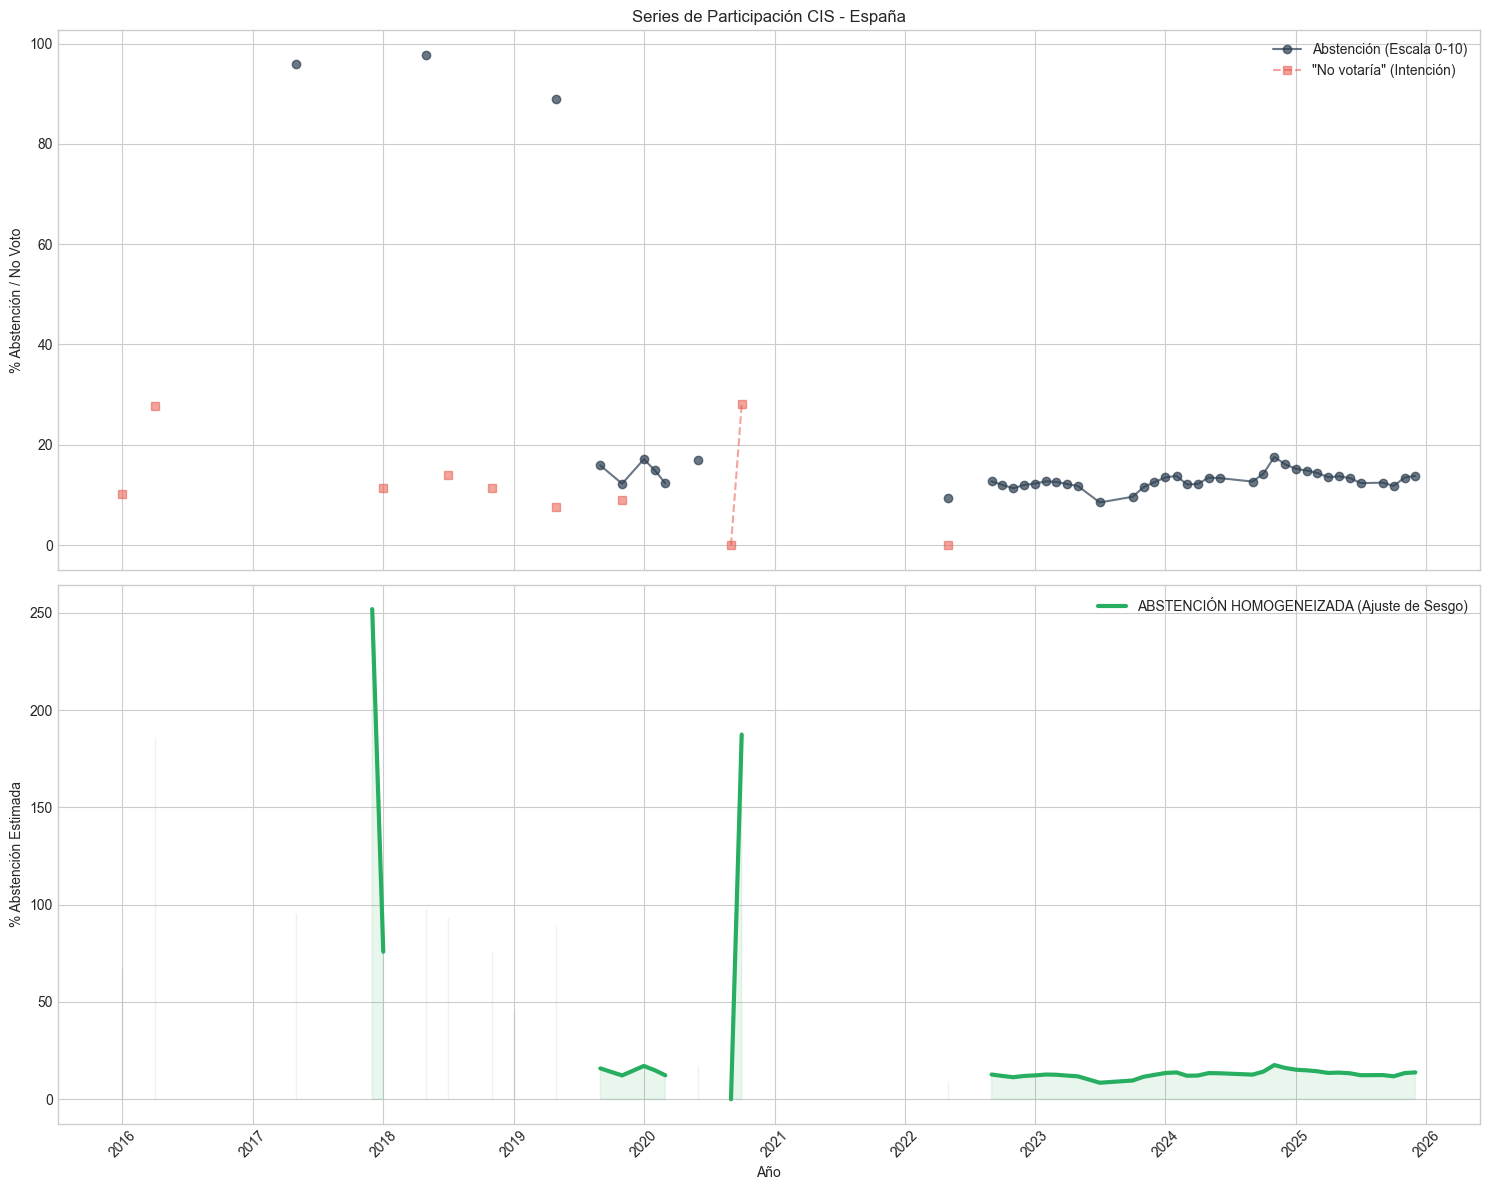

In [9]:
# =============================================================================
# CELDA 9: VISUALIZACIÓN DE SERIES NACIONALES (ESPAÑA)
# =============================================================================

import matplotlib.dates as mdates

plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# Asegurar que FECHA_DT es datetime para el eje X
df_plot = df_espana.sort_values('FECHA_DT')

# Gráfico 1: Indicadores Individuales
ax1.plot(df_plot['FECHA_DT'], df_plot['ABSTENCION_ESCALA'], 'o-', label='Abstención (Escala 0-10)', color='#2c3e50', alpha=0.7)
ax1.plot(df_plot['FECHA_DT'], df_plot['NO_VOTARIA'], 's--', label='"No votaría" (Intención)', color='#e74c3c', alpha=0.5)
ax1.set_ylabel('% Abstención / No Voto')
ax1.set_title('Series de Participación CIS - España')
ax1.legend(loc='upper right')

# Gráfico 2: Serie Homogeneizada (Ajustada)
ax2.plot(df_plot['FECHA_DT'], df_plot['ABSTENCION_HOMOG'], '-', linewidth=3, label='ABSTENCIÓN HOMOGENEIZADA (Ajuste de Sesgo)', color='#27ae60')
ax2.fill_between(df_plot['FECHA_DT'].values, df_plot['ABSTENCION_HOMOG'], color='#27ae60', alpha=0.1)
ax2.set_ylabel('% Abstención Estimada')
ax2.set_xlabel('Año')
ax2.legend(loc='upper right')

# Formatear eje X
ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax2.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(CARPETA_OUTPUT, 'serie_espana_homogeneizada.png'), dpi=150)
plt.show()


📊 Generando heatmap de abstención por CCAA...


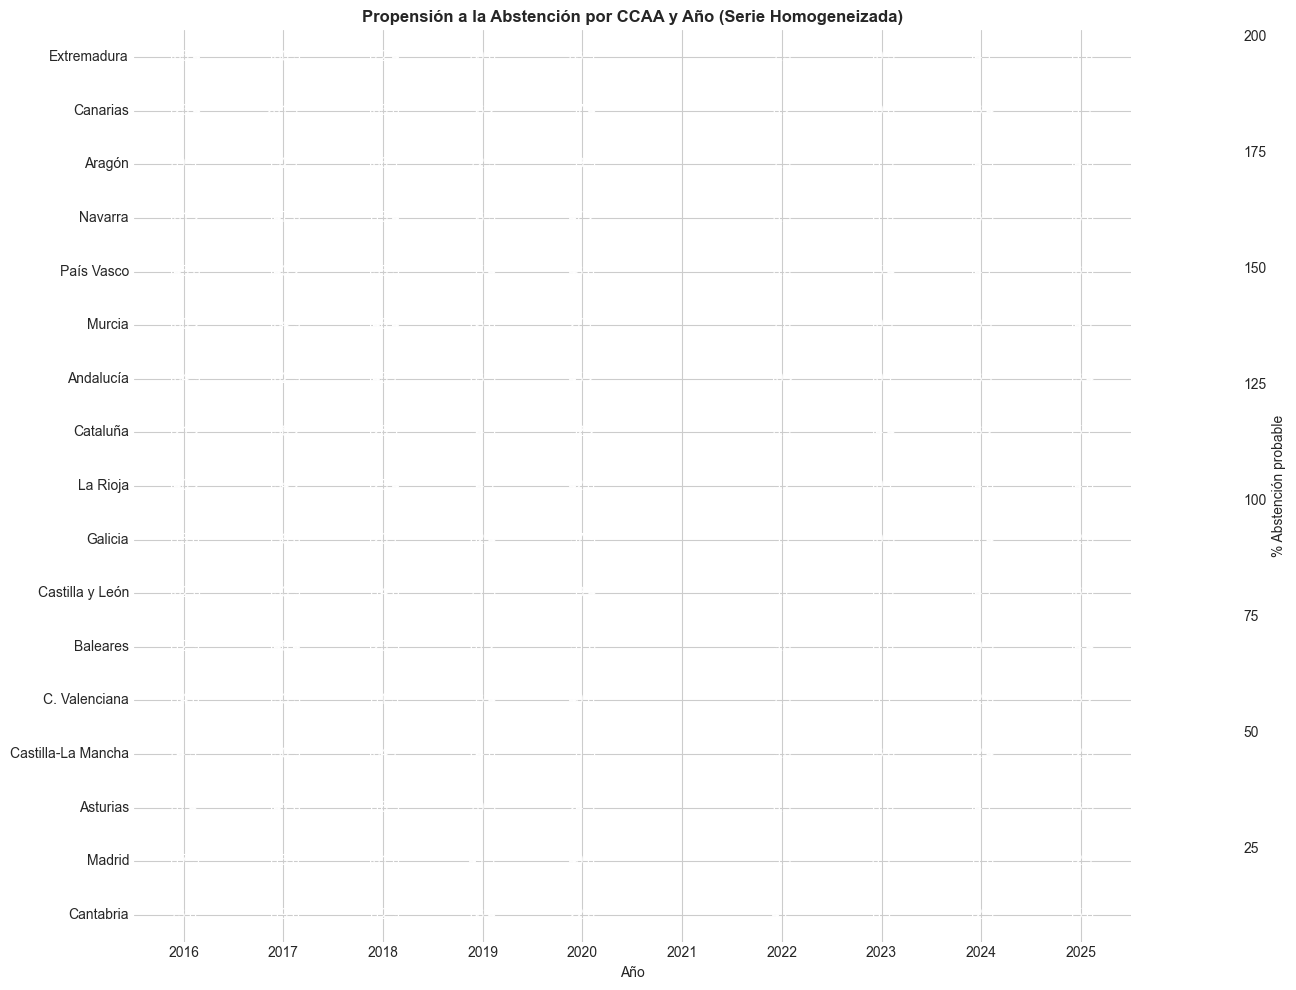


💾 Heatmap guardado


In [10]:
# =============================================================================
# CELDA 10: VISUALIZACIÓN - CCAA (HEATMAP)
# =============================================================================

print("📊 Generando heatmap de abstención por CCAA...")

# Crear tabla pivote: CCAA x Año
df_ccaa['AÑO'] = df_ccaa['FECHA'].str[:4]

# Agregar por año
pivot_data = df_ccaa.groupby(['TERRITORIO', 'AÑO'])['ABSTENCION_HOMOG'].mean().reset_index()
pivot_table = pivot_data.pivot(index='TERRITORIO', columns='AÑO', values='ABSTENCION_HOMOG')

# Ordenar por media
orden = pivot_table.mean(axis=1).sort_values(ascending=False).index
pivot_table = pivot_table.loc[orden]

# Heatmap
fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(pivot_table, annot=True, fmt='.1f', cmap='RdYlGn_r', 
            center=pivot_table.values.mean(), ax=ax,
            cbar_kws={'label': '% Abstención probable'})
ax.set_title('Propensión a la Abstención por CCAA y Año (Serie Homogeneizada)', fontsize=12, fontweight='bold')
ax.set_xlabel('Año')
ax.set_ylabel('')

plt.tight_layout()
plt.savefig(os.path.join(CARPETA_OUTPUT, 'heatmap_abstencion_ccaa.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n💾 Heatmap guardado")

In [11]:
# =============================================================================
# CELDA 11: EXPORTAR DATOS
# =============================================================================

print("💾 Exportando datos...")

# --- Serie España ---
cols_export_esp = ['ESTU', 'FECHA', 'TERRITORIO',
                   'PROBVOTO_MEDIA', 'ABSTENCION_ESCALA', 'N_PROBVOTO',
                   'ABSTENCION_4CAT', 'N_4CAT',
                   'NO_VOTARIA', 'N_NO_VOTARIA',
                   'ABSTENCION_HOMOG', 'FUENTE_HOMOG']
cols_disponibles = [c for c in cols_export_esp if c in df_espana.columns]

df_espana[cols_disponibles].to_csv(
    os.path.join(CARPETA_OUTPUT, 'serie_participacion_espana.csv'),
    index=False, encoding='utf-8-sig'
)
print(f"   ✅ serie_participacion_espana.csv")

# --- Serie CCAA ---
cols_export_ccaa = ['ESTU', 'FECHA', 'CCAA', 'TERRITORIO',
                    'PROBVOTO_MEDIA', 'ABSTENCION_ESCALA', 'N_PROBVOTO',
                    'ABSTENCION_4CAT', 'N_4CAT',
                    'NO_VOTARIA', 'N_NO_VOTARIA',
                    'ABSTENCION_HOMOG', 'FUENTE_HOMOG']
cols_disponibles = [c for c in cols_export_ccaa if c in df_ccaa.columns]

df_ccaa[cols_disponibles].to_csv(
    os.path.join(CARPETA_OUTPUT, 'serie_participacion_ccaa.csv'),
    index=False, encoding='utf-8-sig'
)
print(f"   ✅ serie_participacion_ccaa.csv")

# --- Resumen agregado anual ---
df_espana['AÑO'] = df_espana['FECHA'].str[:4]
resumen_anual = df_espana.groupby('AÑO').agg({
    'PROBVOTO_MEDIA': 'mean',
    'ABSTENCION_ESCALA': 'mean',
    'NO_VOTARIA': 'mean',
    'ABSTENCION_HOMOG': 'mean',
    'ESTU': 'count'
}).round(2)
resumen_anual.columns = ['PROBVOTO_MEDIA', 'ABSTENCION_ESCALA', 'NO_VOTARIA', 'ABSTENCION_HOMOG', 'N_ESTUDIOS']

resumen_anual.to_csv(
    os.path.join(CARPETA_OUTPUT, 'resumen_anual_espana.csv'),
    encoding='utf-8-sig'
)
print(f"   ✅ resumen_anual_espana.csv")

print(f"\n📁 Archivos guardados en: {CARPETA_OUTPUT}")
print(f"\n📊 Resumen anual España:")
print(resumen_anual)

💾 Exportando datos...
   ✅ serie_participacion_espana.csv
   ✅ serie_participacion_ccaa.csv


KeyError: "Column(s) ['PROBVOTO_MEDIA'] do not exist"

🔍 Validación cruzada de indicadores...

📈 Correlación entre indicadores (n=9 estudios):
   ABSTENCION_ESCALA vs NO_VOTARIA: r = -0.518

📊 Ratio medio (Escala/NoVotaría): inf
   → La escala 0-10 captura ~infx más abstención potencial


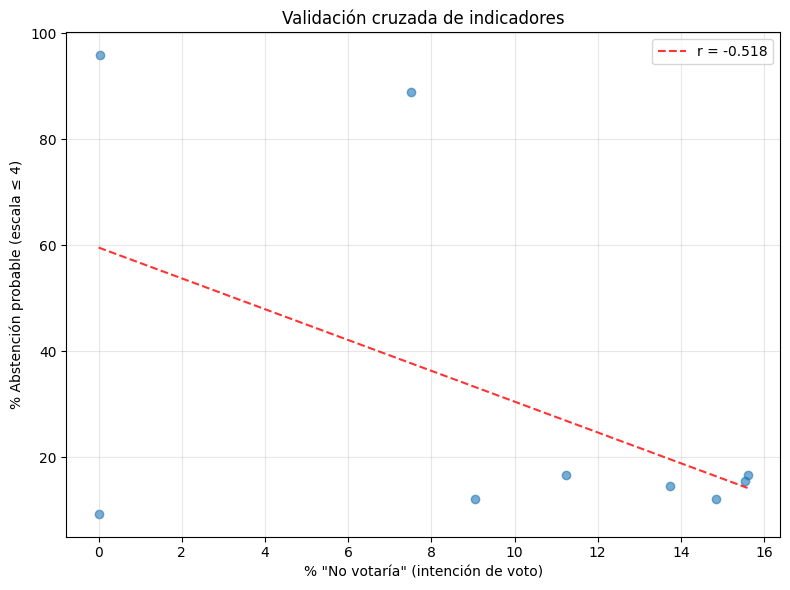


✅ ANÁLISIS COMPLETADO


In [ ]:
# =============================================================================
# CELDA 12: VALIDACIÓN CRUZADA DE INDICADORES
# =============================================================================

print("🔍 Validación cruzada de indicadores...")
print("="*60)

# Estudios donde coinciden escala 0-10 y "No votaría"
df_validacion = df_espana[
    df_espana['ABSTENCION_ESCALA'].notna() & 
    df_espana['NO_VOTARIA'].notna()
].copy()

if len(df_validacion) > 5:
    corr = df_validacion['ABSTENCION_ESCALA'].corr(df_validacion['NO_VOTARIA'])
    
    print(f"\n📈 Correlación entre indicadores (n={len(df_validacion)} estudios):")
    print(f"   ABSTENCION_ESCALA vs NO_VOTARIA: r = {corr:.3f}")
    
    # Ratio medio
    ratio = (df_validacion['ABSTENCION_ESCALA'] / df_validacion['NO_VOTARIA']).mean()
    print(f"\n📊 Ratio medio (Escala/NoVotaría): {ratio:.2f}")
    print(f"   → La escala 0-10 captura ~{ratio:.1f}x más abstención potencial")
    
    # Scatter plot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(df_validacion['NO_VOTARIA'], df_validacion['ABSTENCION_ESCALA'], alpha=0.6)
    
    # Línea de regresión
    z = np.polyfit(df_validacion['NO_VOTARIA'], df_validacion['ABSTENCION_ESCALA'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(df_validacion['NO_VOTARIA'].min(), df_validacion['NO_VOTARIA'].max(), 100)
    ax.plot(x_line, p(x_line), 'r--', alpha=0.8, label=f'r = {corr:.3f}')
    
    ax.set_xlabel('% "No votaría" (intención de voto)')
    ax.set_ylabel('% Abstención probable (escala ≤ 4)')
    ax.set_title('Validación cruzada de indicadores')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(CARPETA_OUTPUT, 'validacion_cruzada.png'), dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("   ⚠️ Insuficientes observaciones para validación cruzada")

print("\n" + "="*60)
print("✅ ANÁLISIS COMPLETADO")
print("="*60)